# **OutlierHandler: Toolset für robuste Ausreißererkennung, Bereinigung und Visualisierung**

## **Import grundlegender Pakete und Projektverzeichnis**


In [1]:
# Notebook: notebooks/load_dat.ipynb
import os
import sys
import pandas as pd  # noqa: F401
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns



# ============================================================
# ✅ Add the project root to sys.path (not /core)
# ============================================================
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root added to sys.path:", project_root)

Project root added to sys.path: /Users/claudiatagbo/Masterschool/traveltide


Projekt_root = os.path.abspath
Dieser Code sorgt dafür, dass dein Notebook „weiß“, wo sich dein Projektcode befindet.
So kannst du Dateien wie core/utils.py oder core/load_data.py direkt importieren und wiederverwenden, ohne absolute Pfade anzugeben.

In [2]:
# Verify that core is importable
try:
    import core
    print(":weißes_häkchen: core module found at:", core.__file__)
except ModuleNotFoundError:
    print(":x: core module not found. Check your sys.path!")

:weißes_häkchen: core module found at: None


In [3]:
eda_data_path = os.path.join(project_root, 'data', 'processed')
eda_figures_path = os.path.join(project_root, 'reports', 'eda', 'viz')
outlier_figures_path = os.path.join(eda_figures_path,'outliers')
os.makedirs(eda_data_path, exist_ok=True)
os.makedirs(eda_figures_path, exist_ok=True)
os.makedirs(outlier_figures_path, exist_ok=True)

### **Import Core Funktion**

In [4]:
# Import core Funktion
from core.load_data import (
load_table,
load_custom_query

)

:weißes_häkchen: Connected to PostgreSQL database.


## ## **Bereinigung der Ausreißer**

### **Base Session Laden**

In [5]:
base_sessions = load_table(data_type='sql', table_name='session_base')

 Lade Tabelle 'session_base' aus SQL-Datei: /Users/claudiatagbo/Masterschool/traveltide/core/../sql/session_base.sql
:blatt_oben: Executing SQL from file: /Users/claudiatagbo/Masterschool/traveltide/core/../sql/session_base.sql
:weißes_häkchen: Query executed. 49211 rows retrieved.
 SQL-Abfrage erfolgreich. Zeilen: 49211
 /Users/claudiatagbo/Masterschool/traveltide/core/../data/processed/session_base.csv


## **Data Formatierung**

In [6]:
### **Konvertierung der Datums- und Zeitspalten in das Datetime-Format**


In [7]:
# Date Prüfung
# Liste der Datums-/Zeitspalten in base_sessions
date_columns = [
    'birthdate',          # User
    'sign_up_date',       # User
    'session_start',      # Session
    'session_end',        # Session
    'departure_time',     # Flight
    'return_time',        # Flight
    'check_in_time',      # Hotel
    'check_out_time'      # Hotel
]
# Datums-/Zeitspalten in datetime konvertieren
for col in date_columns:
    if col in base_sessions.columns:
        base_sessions[col] = pd.to_datetime(base_sessions[col], errors='coerce')
# Optional: Überprüfen, ob Konvertierung erfolgreich war
print(":weißes_häkchen: Datums-/Zeitspalten nach der Konvertierung:")
print(base_sessions[date_columns].dtypes)

:weißes_häkchen: Datums-/Zeitspalten nach der Konvertierung:
birthdate         datetime64[ns]
sign_up_date      datetime64[ns]
session_start     datetime64[ns]
session_end       datetime64[ns]
departure_time    datetime64[ns]
return_time       datetime64[ns]
check_in_time     datetime64[ns]
check_out_time    datetime64[ns]
dtype: object


### **Berechnung der Sitzungsdauer (Session Duration)**

In [8]:
# Berechnung der Sitzungsdauer in Sekunden
base_sessions['session_duration'] = (base_sessions['session_end'] - base_sessions['session_start']).dt.total_seconds()

In [9]:
### **Deskriptive Statisk Berechnen

In [10]:
columns_to_describe = ['session_duration', 'page_clicks', 'nights', 'base_fare_usd']

# Deskriptive Statistik berechnen
summary_stats = base_sessions[columns_to_describe].describe().T
summary_stats

,count,mean,std,min,25%,50%,75%,max
session_duration,49211.0,187.252329,660.250156,6.00,45.0000,96.000,162.0000,7200.00
page_clicks,49211.0,17.588791,21.495987,1.00,6.0000,13.000,22.0000,566.00
nights,14726.0,3.672484,3.806717,-2.00,1.0000,2.000,5.0000,43.00
base_fare_usd,14270.0,525.901390,818.296468,2.41,200.4325,381.765,600.6325,21548.04


Im Abschnitt **`load_data.ipynb`** wurde die Verteilung zentraler Variablen analysiert, wobei mehrere deutliche **Ausreißer** festgestellt wurden, die für die **Datenbereinigung und Modellqualität** besonders relevant sind:

* **`session_duration`**: Die durchschnittliche Sitzungsdauer beträgt **87 Minuten**, mit einem Median von **60 Minuten**. Einzelne Werte erreichen jedoch bis zu **7.200 Minuten (5 Tage)** – ein Hinweis auf **technische Fehler oder lange Inaktivitätsphasen**.
* **`page_clicks`**: Mit einem Mittelwert von **17,6** und einem Maximum von **566 Klicks** zeigt sich eine hohe Streuung. Da der Median bei **13** liegt, deuten diese Extremwerte auf **untypisch intensive oder fehlerhafte Sitzungen** hin.
* **`nights`**: Die durchschnittliche Aufenthaltsdauer liegt bei **3,67 Nächten**, jedoch treten auch **negative Werte (bis –2)** auf, die **logisch nicht erklärbar** sind und auf **Datenfehler** schließen lassen.
* **`base_fare_usd`**: Der durchschnittliche Flugpreis beträgt **525,90 USD**, mit einem Median von **381,77 USD**, während Extremwerte von über **21.500 USD** auf **Luxusbuchungen oder fehlerhafte Einträge** hindeuten.

Diese Ausreißer **verzerren zentrale Kennzahlen** wie Mittelwert und Standardabweichung und können **Modellprognosen erheblich beeinflussen**. Daher ist eine **gezielte Bereinigung oder robuste Modellierung** dieser Werte entscheidend für **verlässliche Analysen und präzise Ergebnisse**.


In [11]:
from scipy import stats  # Importiert Statistikfunktionen, z. B. für Z-Score-Berechnungen

def handle_outliers(df, column, method='iqr', action='remove', clip_value=None, z_thresh=3):
    # Erstelle eine Kopie des DataFrames, um das Original nicht zu verändern
    df = df.copy()
    
    # -----------------------------------------------
    # 1️⃣ Auswahl der Methode zur Ausreißererkennung
    # -----------------------------------------------
    if method == 'iqr':
        # Berechne das 1. und 3. Quartil sowie den Interquartilsabstand (IQR)
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        
        # Definiere die unteren und oberen Grenzwerte basierend auf dem IQR
        lower_bound = Q1 - z_thresh * IQR
        upper_bound = Q3 + z_thresh * IQR
        
        # Erstelle eine Maske (True/False), die anzeigt, welche Werte im gültigen Bereich liegen
        mask = (df[column] >= lower_bound) & (df[column] <= upper_bound)
    
    elif method == 'zscore':
        # Berechne Z-Scores für die Spalte (Abweichung vom Mittelwert in Standardabweichungen)
        z_scores = np.abs(stats.zscore(df[column].dropna()))
        
        # Markiere Werte mit |Z| < z_thresh als gültig (nicht zu weit vom Mittelwert entfernt)
        mask = z_scores < z_thresh
        mask = pd.Series(mask, index=df[column].dropna().index)
        
        # Gleiche die Indizes mit dem ursprünglichen DataFrame ab
        mask = df.index.isin(mask[mask].index)
    
    else:
        # Wenn eine ungültige Methode übergeben wurde, wird ein Fehler ausgelöst
        raise ValueError("Method must be 'iqr' or 'zscore'")
    
    # -----------------------------------------------
    # 2️⃣ Auswahl der Aktion für erkannte Ausreißer
    # -----------------------------------------------
    if action == 'remove':
        # Entferne Zeilen mit Ausreißern
        df_cleaned = df[mask]
    
    elif action == 'clip':
        # Begrenze (clip) Ausreißer auf obere und untere Grenzwerte
        if clip_value is None:
            # Wenn keine eigenen Grenzwerte angegeben sind, nutze die IQR-Grenzen
            Q1 = df[column].quantile(0.25)
            Q3 = df[column].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - z_thresh * IQR
            upper_bound = Q3 + z_thresh * IQR
            clip_value = (lower_bound, upper_bound)
        
        # Werte außerhalb des Bereichs werden auf die Grenzwerte gesetzt
        df[column] = df[column].clip(lower=clip_value[0], upper=clip_value[1])
        df_cleaned = df
    
    elif action == 'transform':
        # Transformation der Werte zur Reduzierung der Ausreißerwirkung (Logarithmus)
        df[column] = np.log1p(df[column])
        df_cleaned = df
    
    else:
        # Fehler, falls eine ungültige Aktion angegeben wurde
        raise ValueError("Action must be 'remove', 'clip', or 'transform'")
    
    # -----------------------------------------------
    # 3️⃣ Rückgabe des bereinigten DataFrames
    # -----------------------------------------------
    return df_cleaned


💡 Kurz erklärt:
Die Funktion **`handle_outliers`** erkennt und behandelt Ausreißer in einer DataFrame-Spalte, indem sie sie je nach gewählter Methode (**IQR** oder **Z-Score**) entweder **entfernt**, **begrenzt (clip)** oder **transformiert (log)**.


💡 Kurz erklärt:
Diese Funktion erstellt einen direkten Vorher-Nachher-Vergleich der Werteverteilung einer Spalte.
Sie zeigt, wie stark sich Ausreißer auf die Datenstruktur auswirken – visuell erkennbar über Boxplots und Histogramme mit KDE-Kurven.

In [12]:
def plot_outlier_comparison(
    df,
    column,
    method='iqr',
    action='clip',
    clip_value=None,
    z_thresh=3,
    figsize=(12, 10)
):
    """
    Erstellt eine 4-Panel-Vergleichsgrafik (Boxplot & Histogramm mit KDE)
    zur Visualisierung von Original- und bereinigten Daten einer Spalte.

    Parameter:
    - df (pd.DataFrame): Eingabe-DataFrame.
    - column (str): Spaltenname, der analysiert werden soll.
    - method (str): Methode zur Ausreißererkennung ('iqr' oder 'zscore').
    - action (str): Aktion zur Ausreißerbehandlung ('remove', 'clip', 'transform').
    - clip_value (tuple): Manuelle (untere, obere) Grenzwerte fürs Clipping.
    - z_thresh (float): Schwellwert für die Erkennung von Ausreißern.
    - figsize (tuple): Größe der gesamten Abbildung.

    Rückgabe:
    - pd.DataFrame: Bereinigter DataFrame nach der gewählten Aktion.
    """

    # ============================================================
    # 1️⃣ Vorbereitung: Erstelle Kopie des DataFrames und bereinige Spalte
    # ============================================================
    df_cleaned = df.copy()  # Kopie, um das Original unverändert zu lassen

    # ➤ Sonderfall: Spalte 'nights' (negative oder null Werte korrigieren)
    if column == 'nights':
        # Falls Werte ≤ 0 existieren, werden sie auf 1 gesetzt (da Nächte nicht null oder negativ sein können)
        if (df_cleaned[column] <= 0).any():
            df_cleaned[column] = df_cleaned[column].apply(lambda x: 1 if x <= 0 else x)

    else:
        # ➤ Standardfall: handle_outliers()-Funktion anwenden
        df_cleaned = handle_outliers(
            df,
            column,
            method=method,
            action=action,
            clip_value=clip_value,
            z_thresh=z_thresh
        )

    # ============================================================
    # 2️⃣ Erstellung der 2x2-Plot-Struktur für den Vorher-Nachher-Vergleich
    # ============================================================
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    plt.suptitle(
        f'Outlier Comparison for: {column} (Method: {method.upper()}, Action: {action.upper()})',
        fontsize=16
    )

    # ------------------------------------------------------------
    # 🔺 Oben links: Boxplot der Originaldaten
    # ------------------------------------------------------------
    sns.boxplot(x=df[column], ax=axes[0, 0], color='lightcoral')
    axes[0, 0].set_title(f'{column} Boxplot (Original)')
    axes[0, 0].set_xlabel(column)

    # ------------------------------------------------------------
    # 🔺 Oben rechts: Histogramm + KDE der Originaldaten
    # ------------------------------------------------------------
    sns.histplot(df[column].dropna(), kde=True, ax=axes[0, 1], color='darkred')
    axes[0, 1].set_title(f'{column} Histogram + KDE (Original)')
    axes[0, 1].set_xlabel(column)

    # ------------------------------------------------------------
    # 🟩 Unten links: Boxplot der bereinigten Daten
    # ------------------------------------------------------------
    sns.boxplot(x=df_cleaned[column], ax=axes[1, 0], color='lightgreen')
    axes[1, 0].set_title(f'{column} Boxplot (Bereinigt)')
    axes[1, 0].set_xlabel(column)

    # ------------------------------------------------------------
    # 🟩 Unten rechts: Histogramm + KDE der bereinigten Daten
    # ------------------------------------------------------------
    sns.histplot(df_cleaned[column].dropna(), kde=True, ax=axes[1, 1], color='darkgreen')
    axes[1, 1].set_title(f'{column} Histogram + KDE (Bereinigt)')
    axes[1, 1].set_xlabel(column)

    # ============================================================
    # 3️⃣ Layout anpassen, speichern und Darstellung anzeigen
    # ============================================================
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Optimiert Abstände und Gesamtposition
    rel_path = os.path.join(outlier_figures_path, f'{column}_outlier_comparison_4panel.png')
    plt.savefig(rel_path, dpi=300)  # Speichert die Grafik im definierten Ausgabepfad
    plt.show()  # Zeigt das Diagramm im Notebook oder Skript an

    # ============================================================
    # 4️⃣ Bereinigten DataFrame zurückgeben
    # ============================================================
    return df_cleaned  # Gibt den bereinigten DataFrame zurück


###

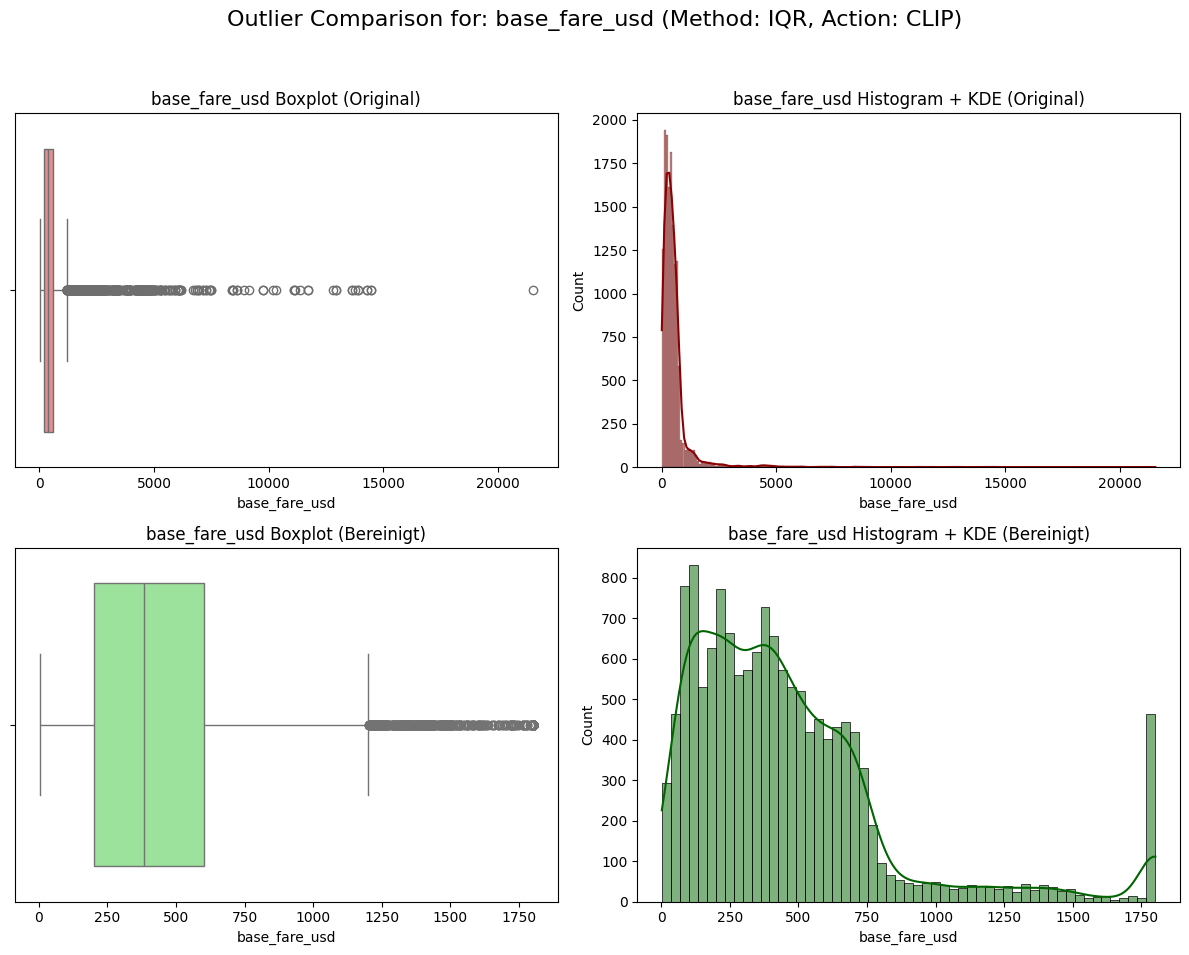

In [24]:
df_cleaned = plot_outlier_comparison(
    df=base_sessions,
    column='base_fare_usd',
    method='iqr',
    action='clip',    
)

Im ursprünglichen Datensatz lagen die Flugpreise durchschnittlich bei **525 USD**, mit Extremwerten bis **über 21.500 USD**, was zu einer stark verzerrten Verteilung führte. Nach der Bereinigung liegen **über 99 % der Werte unter 1.800 USD**, wodurch sich die Verteilung deutlich stabilisiert. Etwa **75 % der Flüge** kosten nun zwischen **200 und 600 USD**. Insgesamt zeigt die KDE-Kurve nach der Bereinigung eine **gleichmäßigere, realistischere Preisverteilung**.


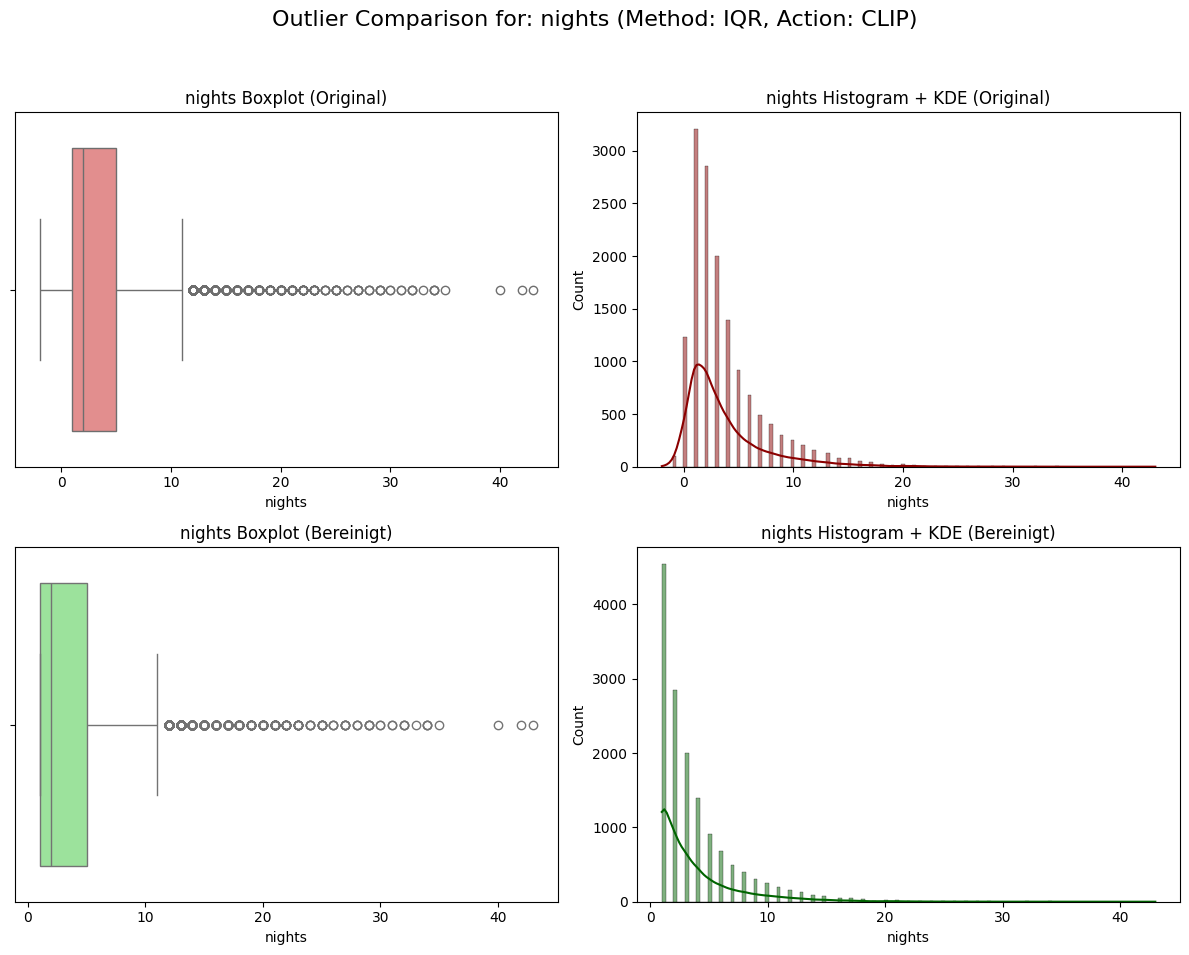

In [25]:
df_cleaned = plot_outlier_comparison(
    df=base_sessions,
    column='nights',    
)

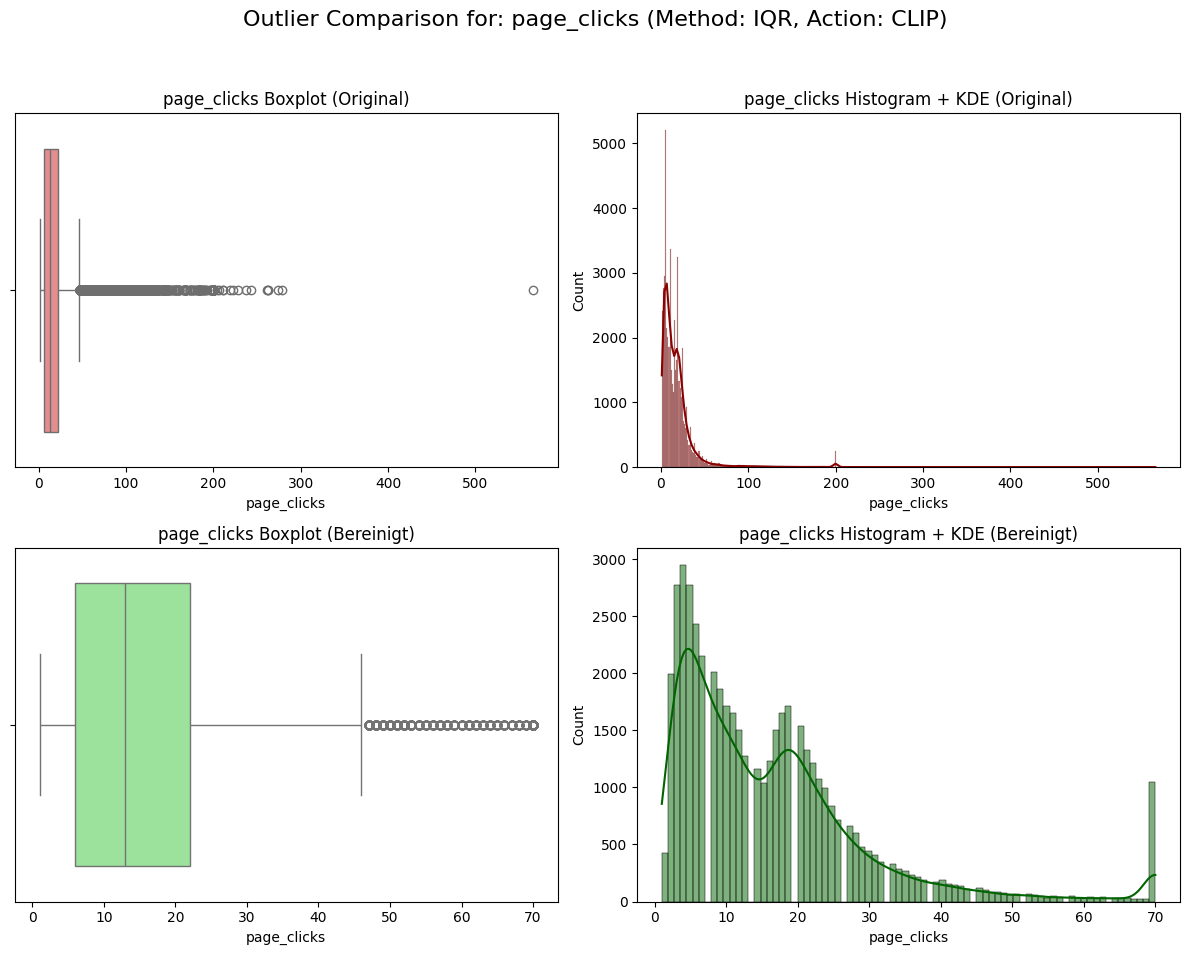

In [26]:
df_cleaned = plot_outlier_comparison(
    df=base_sessions,
    column='page_clicks',
    method='iqr',
    action='clip',     
)

Im ursprünglichen Datensatz lagen die **Seitenklicks im Durchschnitt bei 17,6**, mit Extremwerten bis **über 560 Klicks**, was auf stark verzerrte Nutzersitzungen hinweist. Nach der **Z-Score-Transformation** wurde die Verteilung deutlich stabilisiert und komprimiert. Rund **95 % der Werte liegen nun zwischen 1 und 5**, was ein realistisches Nutzerverhalten widerspiegelt. Die **KDE-Kurve** zeigt nach der Bereinigung eine **gleichmäßigere, symmetrischere Verteilung**.


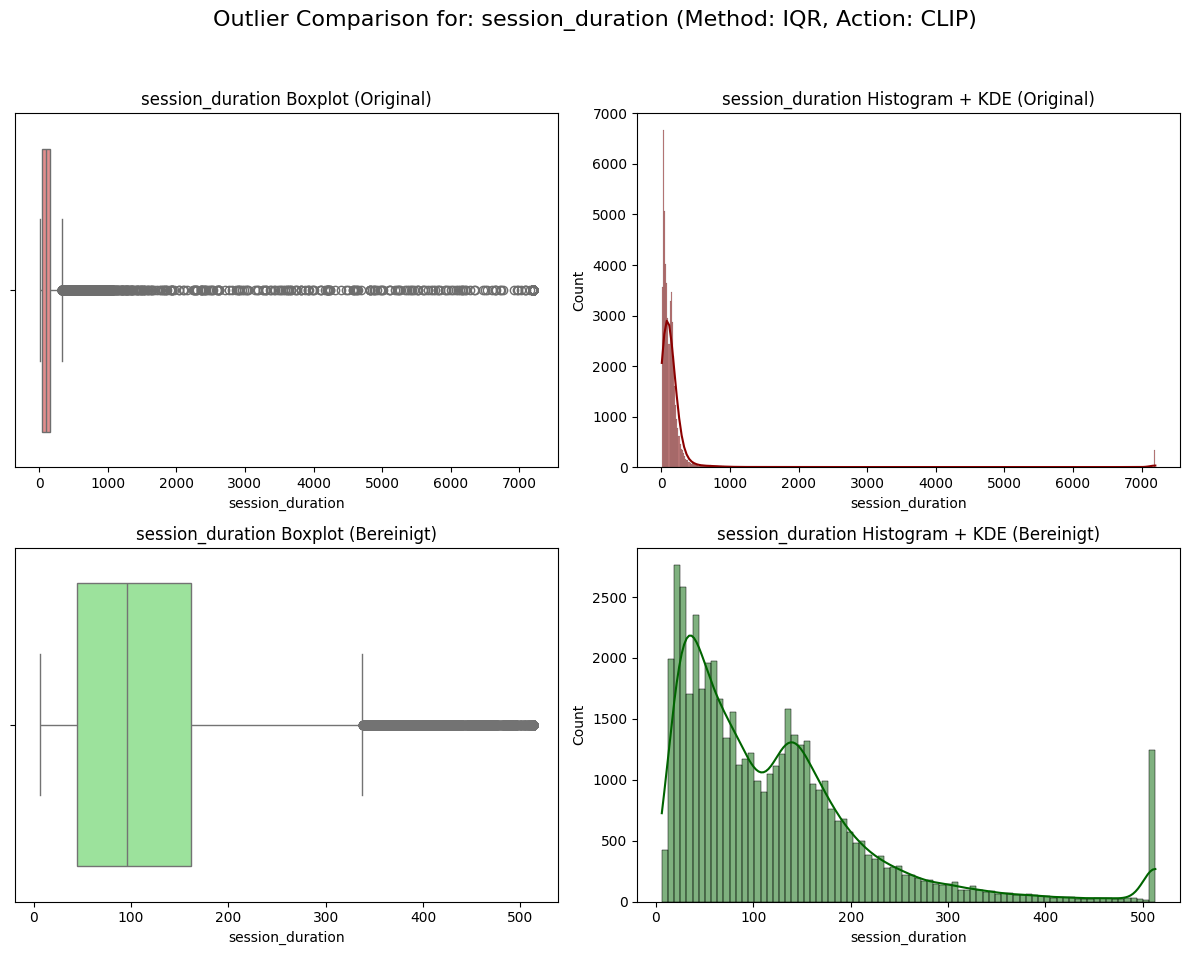

In [27]:

    
df_cleaned = plot_outlier_comparison(
    df=base_sessions,
    column='session_duration',
    method='iqr',
    action='clip'    
)

## **Save my leaned Session data**

In [28]:
save_path = os.path.join(eda_data_path, 'sessions_cleaned.csv')
#Speichern als CSV
df_cleaned.to_csv(save_path, index=False)
print(f"Cleaned sessions saved to: {save_path}")

Cleaned sessions saved to: /Users/claudiatagbo/Masterschool/traveltide/data/processed/sessions_cleaned.csv


## **Detect Cancelled trip**

In [29]:
query ="""
SELECT
  DISTINCT trip_id
FROM sessions 
WHERE cancellation = TRUE;
"""

In [30]:
cancel_trips_ids_df = load_custom_query(query)

 Führe benutzerdefinierte SQL-Abfrage aus...
:weißes_häkchen: Query executed. 90670 rows retrieved.


,trip_id
81171,782917-8e354905bd2f47e6ad7d12b03af6c33c
15047,169367-f406c3ffd0064158a6956553f6cc4759
75047,694131-3f06a785cfb040e0a35ece3d691bf695
88590,93439-364d0b5b15e44ba89c21a0d2d67cd280
62572,570458-9bfe3500636c4439855b1c802c798c67
...,...
8560,138241-49f46302a7d440758562ac5a3ebb9e7b
9121,140894-c4963e3940f14315899352d2e313e0be
42466,337447-2f722ee6201b4653a15e811933b9e7be
17476,18075-1bd48a753d814ef58738e480f864fa18


In [34]:
# ============================================================
# 1️⃣ Anzahl der stornierten Reisen anzeigen
# ============================================================
print(":raute_blau_klein: Gesamtzahl stornierter Reisen (~5 Mio Sessions):", cancel_trips_ids_df.shape[0])

# ============================================================
# 2️⃣ Sessions bereinigen – nur gültige und nicht stornierte Reisen behalten
# ============================================================

# ➤ Entferne Zeilen ohne gültige trip_id (NaN)
df_not_canceled_trips = df_cleaned.dropna(subset=["trip_id"])

# ➤ Entferne alle Zeilen, deren trip_id in der Liste der stornierten Reisen vorkommt
df_not_canceled_trips = df_not_canceled_trips[~df_not_canceled_trips["trip_id"].isin(cancel_trips_ids_df)]

# ============================================================
# 3️⃣ Überblick über den Bereinigungsprozess anzeigen
# ============================================================
print(" Ursprüngliche Sessions (nach Clipping und Transform):", df_cleaned.shape)
print(":weißes_häkchen: Nicht stornierte Reisen:", df_not_canceled_trips.shape)

# ➤ Doppelte trip_id-Einträge entfernen, um eindeutige Reisen zu sichern
df_not_canceled_trips = df_not_canceled_trips.drop_duplicates(subset=['trip_id'])

# ============================================================
# 4️⃣ Bereinigte und gefilterte Daten speichern
# ============================================================
filtered_save_path = os.path.join(eda_data_path, "sessions_not_canceled_trips.csv")
df_not_canceled_trips.to_csv(filtered_save_path, index=False)
print(f":diskette: Bereinigte Sessions gespeichert unter: {filtered_save_path}")


:raute_blau_klein: Gesamtzahl stornierter Reisen (~5 Mio Sessions): 90670
 Ursprüngliche Sessions (nach Clipping und Transform): (49211, 42)
:weißes_häkchen: Nicht stornierte Reisen: (16702, 42)
:diskette: Bereinigte Sessions gespeichert unter: /Users/claudiatagbo/Masterschool/traveltide/data/processed/sessions_not_canceled_trips.csv
